## Imports  

In [1]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch
import pandas as pd
from datasets import Dataset
import seaborn as sns       

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensor="pt")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 0}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dataset_filename = "../../preprocessing/data/processed_merge.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [8]:
data

,scenario,source_file,original_text,preprocessed_text,label
0,Sandwich,richardson174.cha,okay . [+ exc] 564200_564650,okay.,0
1,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
2,Window,capilouto44a.cha,where he is beside him . 1304770_1306020,where he is beside him.,0
3,Umbrella,62-1.cha,it's pouring . 794962_795602,it's pouring.,0
4,Umbrella,wright34a.cha,&-uh every morning mommy gets Billy ready for ...,every morning mommy gets billy ready for school.,0
...,...,...,...,...,...
57046,Important_Event,UNH1034.cha,something that was so foreign to me to just as...,something that was so foreign to me to just as...,0
57047,Cinderella,UMD24.cha,the prince continues to wave her away . 13682...,the prince continues to wave her away.,0
57048,Cinderella,UNH1034.cha,and she was off to the ball . 1993565_1994535,and she was off to the ball.,0
57049,Umbrella,adler11a.cha,yeah &=points:frame_5 . [+ exc] 694075_694992,yeah.,1


In [10]:
data["label"].value_counts()

label
0    41095
1    15956
Name: count, dtype: int64

In [11]:
dataset = Dataset.from_pandas(data)

In [12]:
dataset

Dataset({
    features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label'],
    num_rows: 57051
})

In [13]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    print(metric_res)
    return metric_res

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["preprocessed_text"], padding=True, truncation=True, return_tensors="pt")

In [15]:
tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")

Map:   0%|          | 0/57051 [00:00<?, ? examples/s]

In [16]:
tokenized_data_split = tokenized_data.train_test_split(test_size=0.2, seed=42)

In [17]:
tokenized_data_split['test']['label']

tensor([0, 0, 0,  ..., 0, 1, 0])

In [19]:
training_args = TrainingArguments(
    output_dir="../models/bert_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model('../models/bert_finetuned')

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\accelerate\accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'accuracy': 0.9177109806327228, 'recall': 0.799373040752351, 'precision': 0.8950508950508951, 'f1': 0.8445106805762544}
{'accuracy': 0.9204276575234422, 'recall': 0.8385579937304075, 'precision': 0.871903520208605, 'f1': 0.8549057206775328}


In [20]:
trainer.evaluate()

{'accuracy': 0.9177109806327228, 'recall': 0.799373040752351, 'precision': 0.8950508950508951, 'f1': 0.8445106805762544}


{'eval_loss': 0.21896517276763916,
 'eval_accuracy': 0.9177109806327228,
 'eval_recall': 0.799373040752351,
 'eval_precision': 0.8950508950508951,
 'eval_f1': 0.8445106805762544,
 'eval_runtime': 21.1383,
 'eval_samples_per_second': 539.826,
 'eval_steps_per_second': 33.778,
 'epoch': 2.0}

# Evaluate model

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [28]:
sentences = tokenized_data_split["test"]["preprocessed_text"]
true_labels = tokenized_data_split["test"]["label"] 

In [29]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device) 
    
    with torch.no_grad():
        logits = model(inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)

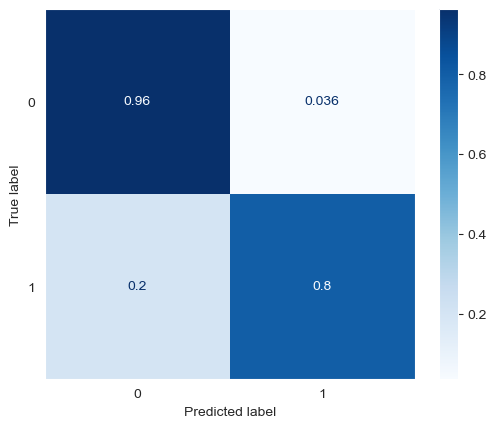

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [31]:
accuracy_score(true_labels, pred_labels)

0.9177109806327228

In [32]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9564815287972639
0.799373040752351
0.8708984916606689


# Feature visualization

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [34]:
def extract_hidden_states(batch):
    sentences = [x for x in batch["preprocessed_text"]]
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        last_hidden_state = model(inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [35]:
hidden = tokenized_data_split.map(
    extract_hidden_states, batched=True)

Map:   0%|          | 0/45640 [00:00<?, ? examples/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Map:   0%|          | 0/11411 [00:00<?, ? examples/s]

In [36]:
hidden.save_to_disk('../models/bert_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/45640 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11411 [00:00<?, ? examples/s]

In [37]:
hidden["test"].column_names

['scenario',
 'source_file',
 'original_text',
 'preprocessed_text',
 'label',
 'input_ids',
 'attention_mask',
 'hidden state']

In [38]:
print(np.array(hidden["train"]["hidden state"]).shape)

(45640, 768)


In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_train = np.array(hidden["train"]["hidden state"])
y_train = np.array(hidden["train"]["label"])

X_test = np.array(hidden["test"]["hidden state"])
y_test = np.array(hidden["test"]["label"])

In [40]:
# reduce to 2d for visualization
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_2d1 = pca.fit_transform(x_scaled1)
x_2d1.shape

(11411, 2)

In [45]:
# reduce to 3d for visualization
pca = PCA(n_components=3)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_3d = pca.fit_transform(x_scaled)
x_3d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_3d1 = pca.fit_transform(x_scaled1)
x_3d1.shape

(11411, 3)

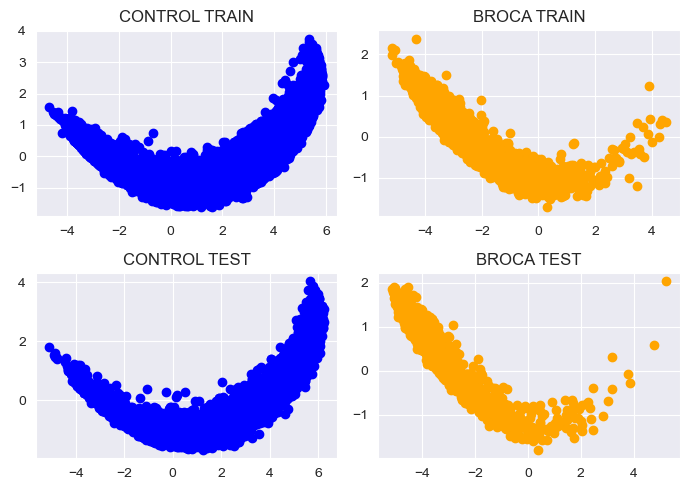

In [44]:
# 2d viz
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].scatter(x_2d_sub[:, 0], x_2d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label] +" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub1 = x_2d1[y_test == i]
    ax[i+2].scatter(x_2d_sub1[:, 0], x_2d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label] +" TEST" )

plt.tight_layout()
plt.show()

### Shows us that there might be an overlap in control text and broca text which indistinguishable to the model (so model goes with control as sort of default strategy)

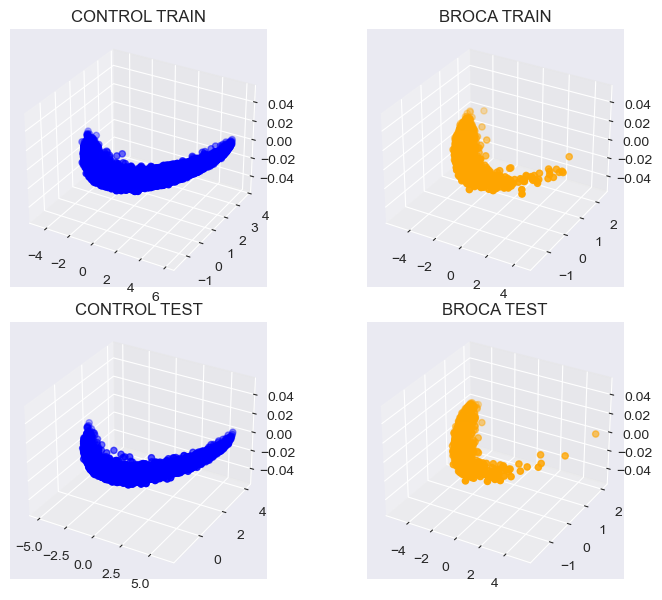

In [43]:
# 3d vis

fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub = x_3d[y_train == i]
    ax[i].scatter(x_3d_sub[:, 0], x_3d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label]+" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub1 = x_3d1[y_test == i]
    ax[i+2].scatter(x_3d_sub1[:, 0], x_3d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label]+" TEST" )

plt.tight_layout()
plt.show()

# Attention viz

In [46]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### For control sentence

In [63]:
input = tokenizer.encode(sentences[0], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[0], true_labels[0])

<IPython.core.display.Javascript object>

i usually use a spoon for my jelly. tensor(0)


### For broca sentence

In [70]:
input = tokenizer.encode(sentences[8], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[8], true_labels[8])

<IPython.core.display.Javascript object>

and they one one to. tensor(1)
